<a href="https://colab.research.google.com/github/TimotheeeNiven/IntroML_TNiven/blob/main/Homework2_TNivenDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
def alexnet(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [4]:
def alexnet_with_dropout(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))  # Dropout layer
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [5]:
class BasicBlock(nn.Module):
    expansion = 1  # Expansion factor to adjust the number of output channels if needed

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization after the first convolution

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization after the second convolution

        # Shortcut connection to match input and output dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # Forward pass through the first convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through the second convolution and batch norm
        out = self.bn2(self.conv2(out))
        # Adding the shortcut connection's output to the main path's output
        out += self.shortcut(x)
        # Final ReLU activation after adding the shortcut
        out = F.relu(out)
        return out

In [6]:
class ResNet11(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet11, self).__init__()
        self.in_channels = 64  # Initial number of input channels

        # Initial convolutional layer before entering the residual blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after the initial convolution

        # Creating layers of blocks with increasing channel sizes
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Final fully connected layer for classification
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Helper function to create a layer with specified blocks
        strides = [stride] + [1]*(num_blocks-1)  # First block could have a stride and the rest have stride of 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion  # Update in_channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the initial convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through all the layers of blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pooling before the final layer
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.linear(out)  # Final classification layer
        return out


In [7]:
class ResNet11_with_dropout(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_prob=0.5):
        super(ResNet11_with_dropout, self).__init__()
        self.in_channels = 64  # Initial number of input channels

        # Initial convolutional layer before entering the residual blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after the initial convolution

        # Creating layers of blocks with increasing channel sizes
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_prob=dropout_prob)

        # Final fully connected layer for classification
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout_prob):
        # Helper function to create a layer with specified blocks
        strides = [stride] + [1]*(num_blocks-1)  # First block could have a stride and the rest have stride of 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion  # Update in_channels for the next block
        layers.append(nn.Dropout(dropout_prob))  # Adding dropout after each block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the initial convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through all the layers of blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pooling before the final layer
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.linear(out)  # Final classification layer
        return out


In [8]:
def train_and_validate(net, trainloader, testloader, optimizer, criterion, device, epochs=10):
    train_loss_list = []
    val_loss_list = []
    val_accuracy_list = []

    for epoch in range(epochs):
        running_loss = 0.0
        net.train()  # Set the model to training mode
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_list.append(running_loss / len(trainloader))

        # Validation loop
        running_loss = 0.0
        correct = 0
        total = 0
        net.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss_list.append(running_loss / len(testloader))
        val_accuracy = 100 * correct / total
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

    return train_loss_list, val_loss_list, val_accuracy_list

In [9]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

input_shape = x_train.shape[1:]
num_classes = 10

170498071/170498071 [==============================] - 6s 0us/step


In [30]:
# Instantiate the model
model = alexnet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3976 - accuracy: 0.8646 - val_loss: 0.8218 - val_accuracy: 0.7597
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3949 - accuracy: 0.8668 - val_loss: 0.7868 - val_accuracy: 0.7607
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3836 - accuracy: 0.8701 - val_loss: 0.8717 - val_accuracy: 0.7546
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3746 - accuracy: 0.8757 - val_loss: 0.8890 - val_accuracy: 0.7571
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3654 - accuracy: 0.8779 - val_loss: 0.9084 - val_accuracy: 0.7516
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3630 - accuracy: 0.8781 - val_loss: 0.9202 - val_accuracy: 0.7507
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3426 - accuracy: 0.8850 - val_loss: 0.9048 - val_accuracy:

In [31]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 3s 4ms/step - loss: 2.3034 - accuracy: 0.0949
Test accuracy: 0.09489999711513519


In [ ]:
# Instantiate the model
model1 = alexnet_with_dropout(input_shape, num_classes)

# Compile the model
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now, the model should compile successfully

In [ ]:
history1 = model1.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 15s 6ms/step - loss: 1.6218 - accuracy: 0.3953 - val_loss: 1.2539 - val_accuracy: 0.5432
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2149 - accuracy: 0.5665 - val_loss: 1.0707 - val_accuracy: 0.6208
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0339 - accuracy: 0.6363 - val_loss: 0.9316 - val_accuracy: 0.6672
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9114 - accuracy: 0.6841 - val_loss: 0.8682 - val_accuracy: 0.7044
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8241 - accuracy: 0.7139 - val_loss: 0.8306 - val_accuracy: 0.7152
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7644 - accuracy: 0.7362 - val_loss: 0.7935 - val_accuracy: 0.7322
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7122 - accuracy: 0.7540 - val_loss: 0.7753 - val_accuracy

In [ ]:
test_loss, test_acc = model1.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 1s 2ms/step - loss: 0.8268 - accuracy: 0.7614
Test accuracy: 0.7613999843597412
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168    

In [10]:
model2 = ResNet11(BasicBlock, [1, 1, 1, 1], num_classes=10)  # 4 blocks with 1 layer each
model3 = ResNet11(BasicBlock, [2, 2, 2, 2], num_classes=10)
model4 = ResNet11_with_dropout(BasicBlock, [1, 1, 1, 1], num_classes=10, dropout_prob=0.5)
model5 = ResNet11_with_dropout(BasicBlock, [2, 2, 2, 2], num_classes=10, dropout_prob=0.5)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

Using device: cuda:0


100%|██████████| 170498071/170498071 [00:05<00:00, 29456019.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
# Define the network, for ResNet11
net = model2.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
train_loss_list, val_loss_list, val_accuracy_list = train_and_validate(net, trainloader, testloader, optimizer, criterion, device, epochs=10)

Epoch 1, Training loss: 1.2411134433303974, Validation loss: 1.0273084461498565, Validation Accuracy: 64.59%
Epoch 2, Training loss: 0.7769740402355304, Validation loss: 0.772498437771782, Validation Accuracy: 73.44%
Epoch 3, Training loss: 0.5697507860278442, Validation loss: 0.5908910723063893, Validation Accuracy: 79.29%
Epoch 4, Training loss: 0.4285756182533308, Validation loss: 0.5461777220137964, Validation Accuracy: 81.91%
Epoch 5, Training loss: 0.30745251900537307, Validation loss: 0.5591282695531845, Validation Accuracy: 81.69%
Epoch 6, Training loss: 0.20890210646008614, Validation loss: 0.589189345796649, Validation Accuracy: 82.5%
Epoch 7, Training loss: 0.13498943319105647, Validation loss: 0.6430306776215474, Validation Accuracy: 81.92%
Epoch 8, Training loss: 0.10633076856467547, Validation loss: 0.7138631829438499, Validation Accuracy: 81.46%
Epoch 9, Training loss: 0.07721203624803254, Validation loss: 0.7313061179206394, Validation Accuracy: 82.86%
Epoch 10, Trainin

In [14]:
# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')



Final Validation Accuracy: 82.41%
Total number of parameters in the model: 4903242


In [15]:
# Define the network for ResNet18
net1 = model3.to(device)
optimizer1 = optim.Adam(net1.parameters(), lr=0.001)

In [16]:
train_loss_list1, val_loss_list1, val_accuracy_list1 = train_and_validate(net1, trainloader, testloader, optimizer1, criterion, device, epochs=10)

Epoch 1, Training loss: 1.3588875418890003, Validation loss: 1.0054958807393766, Validation Accuracy: 63.62%
Epoch 2, Training loss: 0.8427316950668682, Validation loss: 0.7234064062563376, Validation Accuracy: 75.1%
Epoch 3, Training loss: 0.6234832899984609, Validation loss: 0.6383118816077138, Validation Accuracy: 77.88%
Epoch 4, Training loss: 0.4808969765672757, Validation loss: 0.5240678460405658, Validation Accuracy: 81.91%
Epoch 5, Training loss: 0.366462946476764, Validation loss: 0.5372581185338596, Validation Accuracy: 82.25%
Epoch 6, Training loss: 0.2687795398946344, Validation loss: 0.5129749916803342, Validation Accuracy: 83.5%
Epoch 7, Training loss: 0.18689744456856489, Validation loss: 0.5967646128120133, Validation Accuracy: 82.31%
Epoch 8, Training loss: 0.13356724671986114, Validation loss: 0.5810205556047611, Validation Accuracy: 83.51%
Epoch 9, Training loss: 0.10682852452061356, Validation loss: 0.618141373744407, Validation Accuracy: 83.97%
Epoch 10, Training l

In [17]:
# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list1[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net1.parameters())
print(f'Total number of parameters in the model: {total_params}')

Final Validation Accuracy: 83.77%
Total number of parameters in the model: 11173962


In [18]:
#Resnet 11 With dropout
# Define the network, loss function, and optimizer
net2 = model4.to(device)
criterion = nn.CrossEntropyLoss()

optimizer2 = optim.Adam(net2.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
train_loss_list2, val_loss_list2, val_accuracy_list2 = train_and_validate(net2, trainloader, testloader, optimizer2, criterion, device, epochs=10)

Epoch 1, Training loss: 1.4084241823439254, Validation loss: 1.1604125113152086, Validation Accuracy: 58.94%
Epoch 2, Training loss: 1.0073725399075604, Validation loss: 0.8215247509768977, Validation Accuracy: 70.8%
Epoch 3, Training loss: 0.8392847104096977, Validation loss: 0.7350657028131211, Validation Accuracy: 74.48%
Epoch 4, Training loss: 0.7218017157212482, Validation loss: 0.6565152261489496, Validation Accuracy: 77.31%
Epoch 5, Training loss: 0.6301930016401251, Validation loss: 0.5812166356526244, Validation Accuracy: 80.09%
Epoch 6, Training loss: 0.5593037267220913, Validation loss: 0.5083985575281393, Validation Accuracy: 82.58%
Epoch 7, Training loss: 0.5016912029137309, Validation loss: 0.5033373930774176, Validation Accuracy: 82.66%
Epoch 8, Training loss: 0.4570756850005035, Validation loss: 0.4432328852316061, Validation Accuracy: 85.3%
Epoch 9, Training loss: 0.42002799299975196, Validation loss: 0.4245661660648002, Validation Accuracy: 85.48%
Epoch 10, Training l

In [20]:
# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list2[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net2.parameters())
print(f'Total number of parameters in the model: {total_params}')

Final Validation Accuracy: 86.24%
Total number of parameters in the model: 4903242


In [21]:
#Resnet 18 With dropout
# Define the network, loss function, and optimizer
net3 = model5.to(device)
criterion = nn.CrossEntropyLoss()

optimizer3 = optim.Adam(net3.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
train_loss_list3, val_loss_list3, val_accuracy_list3 = train_and_validate(net3, trainloader, testloader, optimizer3, criterion, device, epochs=10)

Epoch 1, Training loss: 1.435894511482766, Validation loss: 1.0390066394028954, Validation Accuracy: 62.64%
Epoch 2, Training loss: 0.9890439527887454, Validation loss: 0.837847617487557, Validation Accuracy: 71.08%
Epoch 3, Training loss: 0.7805004821934154, Validation loss: 0.7014767919866421, Validation Accuracy: 75.44%
Epoch 4, Training loss: 0.6527849801042029, Validation loss: 0.6581317810966565, Validation Accuracy: 77.75%
Epoch 5, Training loss: 0.563244638129144, Validation loss: 0.5454564969570111, Validation Accuracy: 81.35%
Epoch 6, Training loss: 0.48879498711436203, Validation loss: 0.4929812067090132, Validation Accuracy: 83.08%
Epoch 7, Training loss: 0.4358854610913851, Validation loss: 0.4544110519293779, Validation Accuracy: 84.27%
Epoch 8, Training loss: 0.3802897802203112, Validation loss: 0.42968966047794294, Validation Accuracy: 85.38%
Epoch 9, Training loss: 0.33452414637830724, Validation loss: 0.41683674289490846, Validation Accuracy: 86.03%
Epoch 10, Training

In [23]:
# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list3[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net3.parameters())
print(f'Total number of parameters in the model: {total_params}')

Final Validation Accuracy: 86.22%
Total number of parameters in the model: 11173962


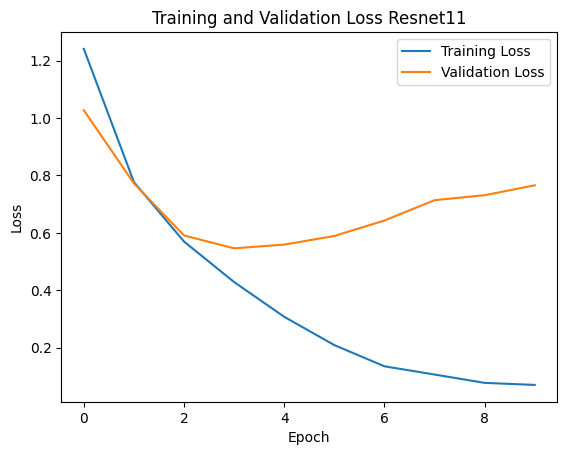

In [25]:
#Resnet 11 Plot
# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Resnet11')
plt.legend()
plt.show()

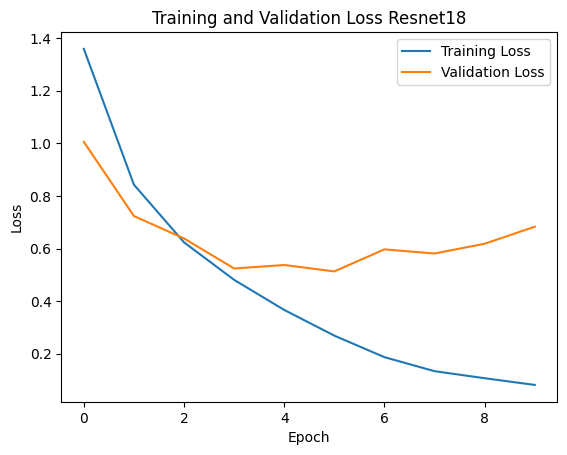

In [26]:
#Resnet 18 Plot
# Plotting training and validation loss
plt.plot(train_loss_list1, label='Training Loss')
plt.plot(val_loss_list1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Resnet18')
plt.legend()
plt.show()

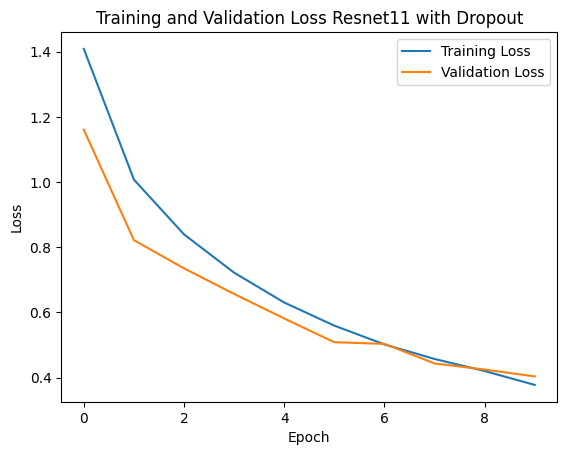

In [27]:
#Resnet 11 Dropout Plot
# Plotting training and validation loss
plt.plot(train_loss_list2, label='Training Loss')
plt.plot(val_loss_list2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Resnet11 with Dropout')
plt.legend()
plt.show()

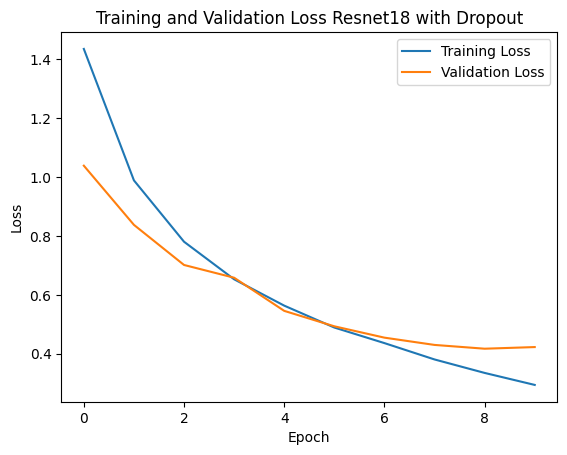

In [28]:
#Resnet 18 Dropout Plot
# Plotting training and validation loss
plt.plot(train_loss_list3, label='Training Loss')
plt.plot(val_loss_list3, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Resnet18 with Dropout')
plt.legend()
plt.show()